In [1]:
import sys
from pathlib import Path
from pprint import pprint

import geopandas as gpd
import pandas as pd
import mizani
import plotnine as gg

sys.path.append("..")
import correlate

tiger = Path("../data-raw/tiger2020pl/tl_2020_42_all.zip")
rdh = Path("../data-raw/rdh/pa")
alarm = Path("../data-raw/alarm-redist-census-2020/census-vest-2020/pa_2020_vtd.csv")
dra = Path("../data-raw/dra2020/2020_VTD/PA/2020_census_PA-2.csv")


In [2]:
# Pull in VTD definitions and county names from TIGER/Line shapefiles

counties = gpd.read_file(
    "zip://" + str(tiger.absolute()) + "!tl_2020_42_county20.shp",
    ignore_geometry=True,
)[["STATEFP20", "COUNTYFP20", "NAME20"]].rename(columns={"NAME20": "CountyName"})

vtds = (
    gpd.read_file("zip://" + str(tiger.absolute()) + "!tl_2020_42_vtd20.shp")
    .merge(counties)
    .set_index("GEOID20")[
        ["STATEFP20", "COUNTYFP20", "NAME20", "CountyName", "geometry"]
    ]
)

vtds.head()


,STATEFP20,COUNTYFP20,NAME20,CountyName,geometry
GEOID20,,,,,
42001000170,42,001,FRANKLIN DISTRICT 01,Adams,"POLYGON ((-77.46876 39.90392, -77.46766 39.903..."
42001000190,42,001,FREEDOM,Adams,"POLYGON ((-77.32236 39.78708, -77.32187 39.788..."
42001000200,42,001,GERMANY,Adams,"POLYGON ((-77.16709 39.71987, -77.16685 39.719..."
42001000260,42,001,HAMILTON,Adams,"POLYGON ((-77.07583 39.89272, -77.07452 39.892..."
42001000230,42,001,GETTYSBURG WARD 02,Adams,"POLYGON ((-77.24600 39.83528, -77.24575 39.836..."


In [3]:
# Pull in county subdivisions. This yields municipality name and type.

subdivisions = gpd.read_file(
    "zip://" + str(tiger.absolute()) + "!tl_2020_42_cousub20.shp"
).merge(
    # https://www2.census.gov/geo/pdfs/reference/LSADCodes.pdf
    pd.DataFrame(
        [
            ("44", "Township"),
            ("21", "Borough"),
            ("25", "City"),
            ("37", "Municipality"),
            ("00", ""),
            ("43", "Town"),
        ],
        columns=["LSAD20", "SubdivisionType"],
    ),
    how="left",
    on=["LSAD20"],
)
assert not subdivisions.SubdivisionType.isna().any()

with_subdivisions = correlate.overlay(
    vtds,
    subdivisions.rename(columns={"NAME20": "SubdivisionName"})[
        ["SubdivisionName", "SubdivisionType", "geometry"]
    ],
)
print(with_subdivisions.format_summary())


Within: 9177
Contained: 1
Partial: 0
No match: 0


In [4]:
with_subdivisions.overlaid.SubdivisionName.value_counts()


Philadelphia    1703
Pittsburgh       402
Upper Darby       71
Erie              63
Allentown         55
                ... 
Walnutport         1
Wind Gap           1
Cornplanter        1
Barkeyville        1
Watts              1
Name: SubdivisionName, Length: 1886, dtype: int64

In [5]:
# Pull in State House shapefiles from TIGER/Line and project them onto VTDs.

sldl20 = gpd.read_file(
    "zip://" + str(tiger.absolute()) + "!tl_2020_42_sldl20.shp",
).set_index("SLDLST20", drop=False)[["SLDLST20", "geometry"]]

with_sldl = correlate.overlay(with_subdivisions.overlaid, sldl20)
print(with_sldl.format_summary())
with_sldl.overlaid.head()


Within: 9092
Contained: 0
Partial: 86
No match: 0


,STATEFP20,COUNTYFP20,NAME20,CountyName,geometry,SubdivisionName,SubdivisionType,SLDLST20
GEOID20,,,,,,,,
42001000170,42,001,FRANKLIN DISTRICT 01,Adams,"POLYGON ((-77.46876 39.90392, -77.46766 39.903...",Franklin,Township,091
42001000190,42,001,FREEDOM,Adams,"POLYGON ((-77.32236 39.78708, -77.32187 39.788...",Freedom,Township,091
42001000200,42,001,GERMANY,Adams,"POLYGON ((-77.16709 39.71987, -77.16685 39.719...",Germany,Township,091
42001000260,42,001,HAMILTON,Adams,"POLYGON ((-77.07583 39.89272, -77.07452 39.892...",Hamilton,Township,193
42001000230,42,001,GETTYSBURG WARD 02,Adams,"POLYGON ((-77.24600 39.83528, -77.24575 39.836...",Gettysburg,Borough,091


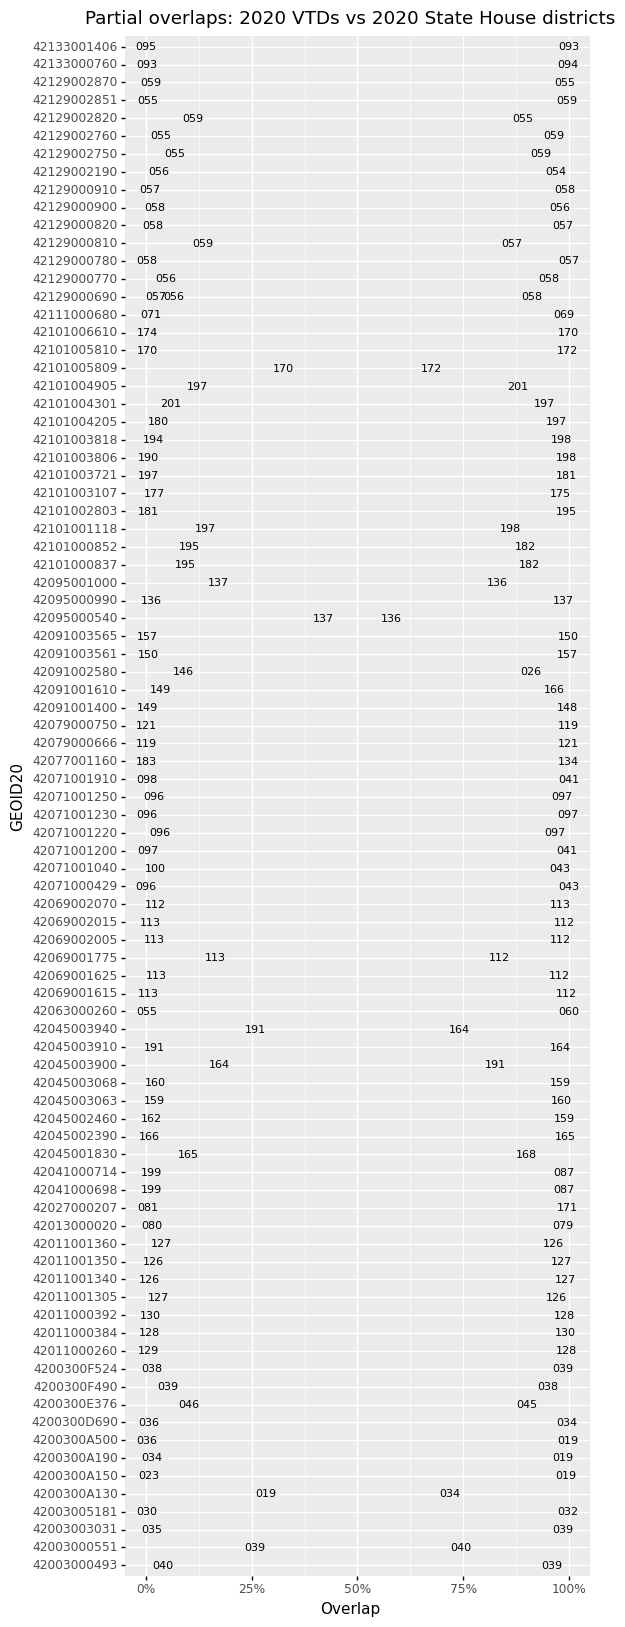

<ggplot: (683987533)>

In [6]:
gg.options.figure_size = (6, 20)
(
    gg.ggplot(
        pd.concat(with_sldl.intersected, names=("GEOID20", "SLDL20")).reset_index(
            name="Overlap"
        ),
        gg.aes("GEOID20", "Overlap", label="SLDL20"),
    )
    + gg.geom_text(size=8)
    + gg.scale_y_continuous(labels=mizani.formatters.percent)
    + gg.coord_flip()
    + gg.labs(title="Partial overlaps: 2020 VTDs vs 2020 State House districts")
)


In [7]:
sldu20 = gpd.read_file(
    "zip://" + str(tiger.absolute()) + "!tl_2020_42_sldu20.shp",
).set_index("SLDUST20", drop=False)[["SLDUST20", "geometry"]]

with_sldu = correlate.overlay(with_sldl.overlaid, sldu20)
print(with_sldu.format_summary())
with_sldu.overlaid.head()


Within: 9164
Contained: 0
Partial: 14
No match: 0


,STATEFP20,COUNTYFP20,NAME20,CountyName,geometry,SubdivisionName,SubdivisionType,SLDLST20,SLDUST20
GEOID20,,,,,,,,,
42001000170,42,001,FRANKLIN DISTRICT 01,Adams,"POLYGON ((-77.46876 39.90392, -77.46766 39.903...",Franklin,Township,091,033
42001000190,42,001,FREEDOM,Adams,"POLYGON ((-77.32236 39.78708, -77.32187 39.788...",Freedom,Township,091,033
42001000200,42,001,GERMANY,Adams,"POLYGON ((-77.16709 39.71987, -77.16685 39.719...",Germany,Township,091,033
42001000260,42,001,HAMILTON,Adams,"POLYGON ((-77.07583 39.89272, -77.07452 39.892...",Hamilton,Township,193,033
42001000230,42,001,GETTYSBURG WARD 02,Adams,"POLYGON ((-77.24600 39.83528, -77.24575 39.836...",Gettysburg,Borough,091,033


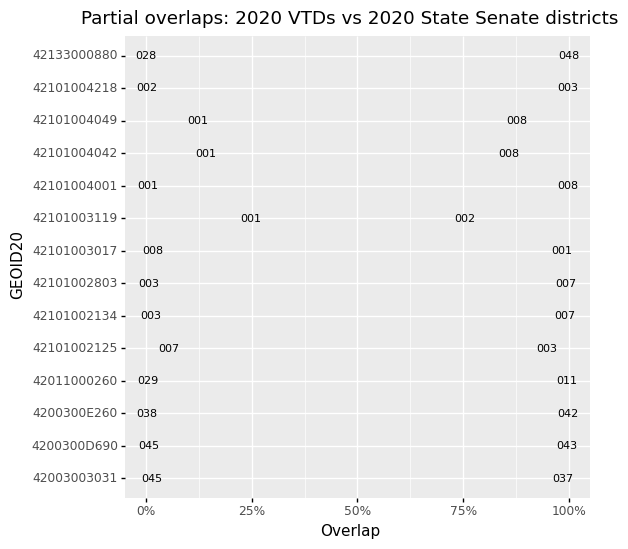

<ggplot: (684192738)>

In [8]:
gg.options.figure_size = (6, 6)
(
    gg.ggplot(
        pd.concat(with_sldu.intersected, names=("GEOID20", "SLDU20")).reset_index(
            name="Overlap"
        ),
        gg.aes("GEOID20", "Overlap", label="SLDU20"),
    )
    + gg.geom_text(size=8)
    + gg.scale_y_continuous(labels=mizani.formatters.percent)
    + gg.coord_flip()
    + gg.labs(title="Partial overlaps: 2020 VTDs vs 2020 State Senate districts")
)


In [9]:
cd116 = gpd.read_file(
    "zip://" + str(tiger.absolute()) + "!tl_2020_42_cd116.shp",
).set_index("CD116FP", drop=False)[["CD116FP", "geometry"]]

with_cd116 = correlate.overlay(with_sldu.overlaid, cd116)
print(with_cd116.format_summary())
with_cd116.overlaid.head()


Within: 9170
Contained: 0
Partial: 8
No match: 0


,STATEFP20,COUNTYFP20,NAME20,CountyName,geometry,SubdivisionName,SubdivisionType,SLDLST20,SLDUST20,CD116FP
GEOID20,,,,,,,,,,
42001000170,42,001,FRANKLIN DISTRICT 01,Adams,"POLYGON ((-77.46876 39.90392, -77.46766 39.903...",Franklin,Township,091,033,13
42001000190,42,001,FREEDOM,Adams,"POLYGON ((-77.32236 39.78708, -77.32187 39.788...",Freedom,Township,091,033,13
42001000200,42,001,GERMANY,Adams,"POLYGON ((-77.16709 39.71987, -77.16685 39.719...",Germany,Township,091,033,13
42001000260,42,001,HAMILTON,Adams,"POLYGON ((-77.07583 39.89272, -77.07452 39.892...",Hamilton,Township,193,033,13
42001000230,42,001,GETTYSBURG WARD 02,Adams,"POLYGON ((-77.24600 39.83528, -77.24575 39.836...",Gettysburg,Borough,091,033,13


In [10]:
# Add redistricted State House districts from Redistricting Hub

sldl22 = (
    gpd.read_file("zip://" + str((rdh / "pa_sldl_adopted_2022.zip").absolute()))
    .rename(columns={"DISTRICT": "SLDLST22"})
    .set_index("SLDLST22", drop=False)[["SLDLST22", "geometry"]]
)

with_sldl22 = correlate.overlay(with_cd116.overlaid, sldl22)
print(with_sldl22.format_summary())
with_sldl22.overlaid.head()


Within: 4809
Contained: 0
Partial: 4369
No match: 0


,STATEFP20,COUNTYFP20,NAME20,CountyName,geometry,SubdivisionName,SubdivisionType,SLDLST20,SLDUST20,CD116FP,SLDLST22
GEOID20,,,,,,,,,,,
42001000170,42,001,FRANKLIN DISTRICT 01,Adams,"POLYGON ((-77.46876 39.90392, -77.46766 39.903...",Franklin,Township,091,033,13,91
42001000190,42,001,FREEDOM,Adams,"POLYGON ((-77.32236 39.78708, -77.32187 39.788...",Freedom,Township,091,033,13,91
42001000200,42,001,GERMANY,Adams,"POLYGON ((-77.16709 39.71987, -77.16685 39.719...",Germany,Township,091,033,13,91
42001000260,42,001,HAMILTON,Adams,"POLYGON ((-77.07583 39.89272, -77.07452 39.892...",Hamilton,Township,193,033,13,193
42001000230,42,001,GETTYSBURG WARD 02,Adams,"POLYGON ((-77.24600 39.83528, -77.24575 39.836...",Gettysburg,Borough,091,033,13,91


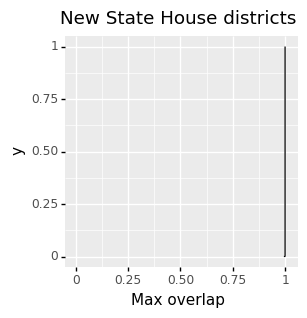

<ggplot: (683999133)>

In [11]:
# This plot shows that, in practice, the new state House districts are expressed exactly in terms of the 2020 VTDs,
# but the edges are a little fuzzy

gg.options.figure_size = (3, 3)
(
    gg.ggplot(
        pd.concat(
            {k: v.iloc[[v.argmax()]] for k, v in with_sldl22.intersected.items()},
            names=("GEOID20", "District"),
        ).reset_index(name="Max overlap"),
        gg.aes("Max overlap"),
    )
    + gg.stat_ecdf()
    + gg.scale_x_continuous(limits=(0, 1.01))
    + gg.labs(title="New State House districts")
)


In [12]:
# Add redistricted State Senate districts from Redistricting Hub

sldu22 = (
    gpd.read_file(rdh / "pa_sldu_adopted_2022.zip")
    .rename(columns={"DISTRICT": "SLDUST22"})
    .set_index("SLDUST22", drop=False)[["SLDUST22", "geometry"]]
)

with_sldu22 = correlate.overlay(with_sldl22.overlaid, sldu22)
print(with_sldu22.format_summary())
with_sldu22.overlaid.head()


Within: 6761
Contained: 0
Partial: 2417
No match: 0


,STATEFP20,COUNTYFP20,NAME20,CountyName,geometry,SubdivisionName,SubdivisionType,SLDLST20,SLDUST20,CD116FP,SLDLST22,SLDUST22
GEOID20,,,,,,,,,,,,
42001000170,42,001,FRANKLIN DISTRICT 01,Adams,"POLYGON ((-77.46876 39.90392, -77.46766 39.903...",Franklin,Township,091,033,13,91,33
42001000190,42,001,FREEDOM,Adams,"POLYGON ((-77.32236 39.78708, -77.32187 39.788...",Freedom,Township,091,033,13,91,33
42001000200,42,001,GERMANY,Adams,"POLYGON ((-77.16709 39.71987, -77.16685 39.719...",Germany,Township,091,033,13,91,33
42001000260,42,001,HAMILTON,Adams,"POLYGON ((-77.07583 39.89272, -77.07452 39.892...",Hamilton,Township,193,033,13,193,33
42001000230,42,001,GETTYSBURG WARD 02,Adams,"POLYGON ((-77.24600 39.83528, -77.24575 39.836...",Gettysburg,Borough,091,033,13,91,33


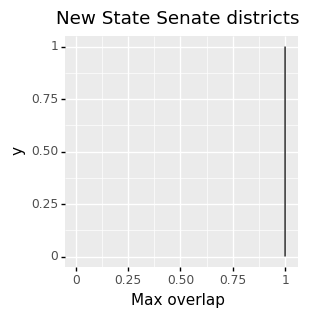

<ggplot: (705969639)>

In [13]:
# This plot shows that, in practice, the new state Senate districts are expressed exactly in terms of the 2020 VTDs,
# but the edges are a little fuzzy

gg.options.figure_size = (3, 3)
(
    gg.ggplot(
        pd.concat(
            {k: v.iloc[[v.argmax()]] for k, v in with_sldu22.intersected.items()},
            names=("GEOID20", "District"),
        ).reset_index(name="Max overlap"),
        gg.aes("Max overlap"),
    )
    + gg.stat_ecdf()
    + gg.scale_x_continuous(limits=(0, 1.01))
    + gg.labs(title="New State Senate districts")
)


In [14]:
# Add redistricted Congressional districts from Redistricting Hub

cdnew = (
    gpd.read_file(rdh / "pa_cong_adopted_2022.zip")
    .rename(columns={"DISTRICT": "CDNew"})
    .set_index("CDNew", drop=False)[["CDNew", "geometry"]]
)

with_cdnew = correlate.overlay(with_sldu22.overlaid, cdnew)
print(with_cdnew.format_summary())
with_cdnew.overlaid.head()


Within: 7712
Contained: 0
Partial: 1466
No match: 0


,STATEFP20,COUNTYFP20,NAME20,CountyName,geometry,SubdivisionName,SubdivisionType,SLDLST20,SLDUST20,CD116FP,SLDLST22,SLDUST22,CDNew
GEOID20,,,,,,,,,,,,,
42001000170,42,001,FRANKLIN DISTRICT 01,Adams,"POLYGON ((-77.46876 39.90392, -77.46766 39.903...",Franklin,Township,091,033,13,91,33,13
42001000190,42,001,FREEDOM,Adams,"POLYGON ((-77.32236 39.78708, -77.32187 39.788...",Freedom,Township,091,033,13,91,33,13
42001000200,42,001,GERMANY,Adams,"POLYGON ((-77.16709 39.71987, -77.16685 39.719...",Germany,Township,091,033,13,91,33,13
42001000260,42,001,HAMILTON,Adams,"POLYGON ((-77.07583 39.89272, -77.07452 39.892...",Hamilton,Township,193,033,13,193,33,13
42001000230,42,001,GETTYSBURG WARD 02,Adams,"POLYGON ((-77.24600 39.83528, -77.24575 39.836...",Gettysburg,Borough,091,033,13,91,33,13


In [15]:
# The new Congressional districts seem to split a handful of VTDs

gg.options.figure_size = (3, 3)
(
    gg.ggplot(
        pd.concat(
            {k: v.iloc[[v.argmax()]] for k, v in with_cdnew.intersected.items()},
            names=("GEOID20", "District"),
        ).reset_index(name="Max overlap"),
        gg.aes("Max overlap"),
    )
    + gg.stat_ecdf()
    + gg.scale_x_continuous(limits=(0, 1.01))
    + gg.labs(title="New Congressional districts")
)


# This shows the maximum overlap:
pd.concat(
    {k: v.iloc[[v.argmax()]] for k, v in with_cdnew.intersected.items()},
    names=("GEOID20", "District"),
).nsmallest(15)


GEOID20      District
42091001135  1           0.565930
42121000740  16          0.589389
42081000722  15          0.635259
42041000630  13          0.641833
42129000820  12          0.683636
42089000240  7           0.696994
42079000152  9           0.698567
42133000420  10          0.727978
42011000840  4           0.736825
4200300F750  17          0.777473
42011000399  4           0.855021
42091001741  5           0.874252
42063000610  14          0.912458
42111000130  13          0.998588
42101003916  3           1.000000
dtype: float64

In [16]:
# Add reaggregated historical election data from ALARM (via VEST)

alarm_df = pd.read_csv(alarm).drop(columns=["state", "county", "vtd"])
with_alarm = with_cdnew.overlaid.merge(
    alarm_df, on="GEOID20", how="left", validate="1:1"
).set_index("GEOID20")

In [17]:
dra_df = pd.read_csv(dra)[["GEOID20", "Tot_2010_tot", "Tot_2010_vap", "Tot_2019_cvap"]]
with_dra = with_alarm.merge(dra_df, on="GEOID20", how="left", validate="1:1").set_index(
    "GEOID20"
)
with_dra.head()


,STATEFP20,COUNTYFP20,NAME20,CountyName,geometry,SubdivisionName,SubdivisionType,SLDLST20,SLDUST20,CD116FP,...,adv_16,arv_18,adv_18,arv_20,adv_20,nrv,ndv,Tot_2010_tot,Tot_2010_vap,Tot_2019_cvap
GEOID20,,,,,,,,,,,,,,,,,,,,,
42001000170,42,001,FRANKLIN DISTRICT 01,Adams,"POLYGON ((-77.46876 39.90392, -77.46766 39.903...",Franklin,Township,091,033,13,...,306.2,577.5,325.1,NaN,NaN,691.7,313.8,2485,1935,1753
42001000190,42,001,FREEDOM,Adams,"POLYGON ((-77.32236 39.78708, -77.32187 39.788...",Freedom,Township,091,033,13,...,160.6,270.5,173.9,NaN,NaN,319.6,165.9,831,672,750
42001000200,42,001,GERMANY,Adams,"POLYGON ((-77.16709 39.71987, -77.16685 39.719...",Germany,Township,091,033,13,...,273.3,784.5,319.0,NaN,NaN,910.4,291.6,2700,2050,2175
42001000260,42,001,HAMILTON,Adams,"POLYGON ((-77.07583 39.89272, -77.07452 39.892...",Hamilton,Township,193,033,13,...,314.0,715.2,344.4,NaN,NaN,880.8,326.1,2530,1930,1928
42001000230,42,001,GETTYSBURG WARD 02,Adams,"POLYGON ((-77.24600 39.83528, -77.24575 39.836...",Gettysburg,Borough,091,033,13,...,799.0,183.5,680.5,NaN,NaN,307.0,751.6,3383,3166,3120


In [18]:
with_dra.drop(columns=["geometry"]).to_csv("pa.csv")

Column | Source | Description
------ | ------ | -----------
STATEFP20 | Census | State FIPS code
COUNTYFP20 | Census | County FIPS code
NAME20 | Census | VTD name
CountyName | Census | County name
SubdivisionName | Census | Name of sub-county division containing the VTD
SubdivisionType | Census | Type of sub-county division containing the VTD
SLDLST20 | Census | Pre-redistricting State House district
SLDUST20 | Census | Pre-redistricting State Senate district
CD116FP | Census | Pre-redistricting Congressional district
SLDLST22 | RDH | Post-redistricting State House district
SLDUST22 | RDH | Post-redistricting State Senate district
CDNew | RDH | Post-redisticting Congressional district
pop | ALARM | 2020 Census population
pop_hisp | ALARM | 2020 Census population (Hispanic)
pop_white | ALARM | 2020 Census population (White)
pop_black | ALARM | 2020 Census population (Black)
pop_aian | ALARM | 2020 Census population (American Indian)
pop_asian  | ALARM | 2020 Census population (Asian)
pop_nhpi | ALARM | 2020 Census population (Hawaiian/Pacific Islander)
pop_other | ALARM | 2020 Census population (Other)
pop_two | ALARM | 2020 Census population (Two or more ethnicities)
vap | ALARM | 2020 Census population (Voting age population)
vap_hisp | ALARM | 2020 Census population (Voting age population; Hispanic)
vap_white | ALARM | 2020 Census population (Voting age population; White)
vap_black | ALARM | 2020 Census population (Voting age population; Black)
vap_aian | ALARM | 2020 Census population (Voting age population; American Indian)
vap_asian | ALARM | 2020 Census population (Voting age population; Asian)
vap_nhpi | ALARM | 2020 Census population (Voting age population; Hawaiian/Pacific Islander)
vap_other | ALARM | 2020 Census population (Voting age population; Other)
vap_two | ALARM | 2020 Census population (Voting age population; Two or more ethnicities)
pre_16_dem_cli | ALARM | Election results
pre_16_rep_tru | ALARM | Election results
uss_16_dem_mcg | ALARM | Election results
uss_16_rep_too | ALARM | Election results
atg_16_dem_sha | ALARM | Election results
atg_16_rep_raf | ALARM | Election results
uss_18_dem_cas | ALARM | Election results
uss_18_rep_bar | ALARM | Election results
gov_18_dem_wol | ALARM | Election results
gov_18_rep_wag | ALARM | Election results
arv_16 | ALARM | Average Republican votes in 2016 elections
adv_16 | ALARM | Average Democratic votes in 2016 elections
arv_18 | ALARM | Average Republican votes in 2018 elections
adv_18 | ALARM | Average Democratic votes in 2018 elections
arv_20 | ALARM | Average Republican votes in 2020 elections
adv_20 | ALARM | Average Democratic votes in 2020 elections
nrv | ALARM | Average Republican votes (all years)
ndv | ALARM | Average Democratic votes (all years)
Tot_2010_tot | DRA | Total 2010 Census population
Tot_2010_vap | DRA | 2010 voting-age population
Tot_2019_cvap | DRA | 2019 voting-age population of US citizens
